In [3]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import random

metadata_base_path = '/content/drive/My Drive/conv/friday'

# Parameters
img_size = 64
vedio_type = 'Grayscale'
batchs = 10
INPUT_SEQ_L = 10
OUTPUT_SEQ_L = 5
SEQ_LENGTH = INPUT_SEQ_L + OUTPUT_SEQ_L

def Loadd(mpath):

    m = pd.read_csv(mpath)
    vpath = m['video'].values
    l = m['label'].values
    return vpath, l

# Convert TensorFlow string tensor to a Python string and split into input and output sequences
def data_parse(vpath, label):


    vpath = vpath.numpy().decode('utf-8')


    v = np.load(vpath)


    if len(v) > SEQ_LENGTH:
        v = v[:SEQ_LENGTH]
    elif len(v) < SEQ_LENGTH:

        padding = np.zeros((SEQ_LENGTH - len(v), img_size, img_size, 1 if vedio_type == 'Grayscale' else 3))
        v = np.concatenate([v, padding], axis=0)


    iseq = v[:INPUT_SEQ_L]
    oseq = v[INPUT_SEQ_L:]

    return iseq, oseq


def prepare_data(m_path, bsize):

    video_paths, labels = Loadd(m_path)


    video_paths_ds = tf.data.Dataset.from_tensor_slices(video_paths)
    labels_ds = tf.data.Dataset.from_tensor_slices(labels)
    dataset = tf.data.Dataset.zip((video_paths_ds, labels_ds))


    def parse_data(path, label):
        inputseq, outputseq = tf.py_function(
            func=data_parse,
            inp=[path, label],
            Tout=(tf.float32, tf.float32)
        )

        inputseq.set_shape((INPUT_SEQ_L, img_size, img_size, 1 if vedio_type == 'Grayscale' else 3))
        outputseq.set_shape((OUTPUT_SEQ_L, img_size, img_size, 1 if vedio_type == 'Grayscale' else 3))
        return inputseq, outputseq

    dataset = dataset.map(parse_data, num_parallel_calls=tf.data.AUTOTUNE)


    dataset = dataset.shuffle(buffer_size=1000).batch(bsize).prefetch(tf.data.AUTOTUNE)
    return dataset


# Load
train_dataset = prepare_data(os.path.join(metadata_base_path, 'train_metadata.csv'), batchs)
val_dataset = prepare_data(os.path.join(metadata_base_path, 'val_metadata.csv'), batchs)
test_dataset = prepare_data(os.path.join(metadata_base_path, 'test_metadata.csv'), batchs)

def info(metadata_path):

    video_paths, labels = Loadd(metadata_path)
    no_vedios = len(video_paths)
    no_classes = len(set(labels))
    t_frames = sum(np.load(path).shape[0] for path in video_paths)

    print(f"Number of Videos: {no_vedios}")
    print(f"Number of Classes: {no_classes}")
    print(f"Total Frames: {t_frames}")

# Example usage for the training dataset
info(os.path.join(metadata_base_path, 'train_metadata.csv'))


for batch_inputs, batch_outputs in train_dataset.take(1):
    print("Batch shape for input:", batch_inputs.shape)
    print("Batch shape for output:", batch_outputs.shape)



for batch_inputs, batch_outputs in train_dataset.take(1):
    print("Batch input shape:", batch_inputs.shape)
    print("Batch output shape:", batch_outputs.shape)



Number of Videos: 510
Number of Classes: 5
Total Frames: 88433
Batch shape for input: (10, 10, 64, 64, 1)
Batch shape for output: (10, 5, 64, 64, 1)


In [16]:
import tensorflow as tf
import numpy as np
from keras.saving import register_keras_serializable



# Parameters
image_s = 64
input_seq_l = 10
output_seq_l = 5
embiding_dimi = 128  # Embedding dimension
heads_n = 4  # Number of attention heads
feed_dim = 512  # Feed-forward hidden layer size
layers_n = 4  # Number of Transformer layer

### Positional Encoding ###
def fun_positional_encoding(p, d_model):
    rads = np.arange(p)[:, np.newaxis] / np.power(
        10000, (2 * (np.arange(d_model)[np.newaxis, :] // 2)) / d_model
    )
    rads[:, 0::2] = np.sin(rads[:, 0::2])
    rads[:, 1::2] = np.cos(rads[:, 1::2])
    return tf.cast(rads, dtype=tf.float32)

In [17]:
@register_keras_serializable()
class MultiHeadSelfAttention(tf.keras.layers.Layer):
    def __init__(self, embiding_dimi, heads_n):
        super(MultiHeadSelfAttention, self).__init__()
        self.embiding_dimi = embiding_dimi
        self.heads_n = heads_n
        self.projection_dim = embiding_dimi // heads_n
        self.query_dense = tf.keras.layers.Dense(embiding_dimi)
        self.key_dense = tf.keras.layers.Dense(embiding_dimi)
        self.value_dense = tf.keras.layers.Dense(embiding_dimi)
        self.combine_heads = tf.keras.layers.Dense(embiding_dimi)

    def sep_head(self, x, batchsize):

        x = tf.reshape(x, (batchsize, -1, self.heads_n, self.projection_dim))

        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs):

        batchsize = tf.shape(inputs)[0]
        query = self.sep_head(self.query_dense(inputs), batchsize)
        key = self.sep_head(self.key_dense(inputs), batchsize)
        value = self.sep_head(self.value_dense(inputs), batchsize)

        # Scaled dot product
        att_score = tf.matmul(query, key, transpose_b=True)
        att_score /= tf.sqrt(tf.cast(self.projection_dim, tf.float32))
        att_weig = tf.nn.softmax(att_score, axis=-1)
        att_output = tf.matmul(att_weig, value)

        att_output = tf.transpose(att_output, perm=[0, 2, 1, 3])
        att_cncat = tf.reshape(att_output, (batchsize, -1, self.embiding_dimi))
        return self.combine_heads(att_cncat)

In [18]:
### Feed-Forward Network ###
@register_keras_serializable()
class feedforward (tf.keras.layers.Layer):

    def __init__(self, embiding_dimi, feed_dim):
        super(feedforward, self).__init__()
        self.dense1 = tf.keras.layers.Dense(feed_dim, activation="relu")
        self.dense2 = tf.keras.layers.Dense(embiding_dimi)

    def call(self, inputs):
        return self.dense2(self.dense1(inputs))

### Transformer Encoder Layer ###
@register_keras_serializable()
class encoderlayer(tf.keras.layers.Layer):
    def __init__(self, embiding_dimi, heads_n, feed_dim, dropout_rate=0.1):
        super(encoderlayer, self).__init__()
        self.attention = MultiHeadSelfAttention(embiding_dimi, heads_n)
        self.ffn = feedforward(embiding_dimi, feed_dim)
        self.layern1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layern2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(dropout_rate)
        self.dropout2 = tf.keras.layers.Dropout(dropout_rate)

    def call(self, input, training):
        att_output = self.dropout1(self.attention(input), training=training)
        out1 = self.layern1(input + att_output)
        ffn_output = self.dropout2(self.ffn(out1), training=training)
        return self.layern2(out1 + ffn_output)

In [19]:
### Transformer Encoder ###
@register_keras_serializable()
class transformeren(tf.keras.layers.Layer):

    def __init__(self, layers_n, embiding_dimi, heads_n, feed_dim, rate=0.1):
        super(transformeren, self).__init__()
        self.layers_n = layers_n
        self.layers = [encoderlayer(embiding_dimi, heads_n, feed_dim, rate) for _ in range(layers_n)]
        self.dropout = tf.keras.layers.Dropout(rate)
        self.pos_encoding = fun_positional_encoding(1000, embiding_dimi)

    def call(self, inp, training=False):
        seq = tf.shape(inp)[1]
        inp += self.pos_encoding[:seq, :]
        for laye in self.layers:
            inp = laye(inp, training=training)
        return inp



  # Flatten spatial dimensions for each frame and project each frame using Dense layer and flatten the transformer output
def predict_model():
    inp_layer = tf.keras.layers.Input(shape=(input_seq_l, image_s, image_s, 1))


    y = tf.keras.layers.Reshape((input_seq_l, image_s * image_s))(inp_layer)


    y = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(embiding_dimi))(y)


    encoder = transformeren(layers_n, embiding_dimi, heads_n, feed_dim)
    y = encoder(y, training=True)


    y = tf.keras.layers.Flatten()(y)
    y = tf.keras.layers.Dense(output_seq_l * image_s * image_s)(y)


    y = tf.keras.layers.Reshape((output_seq_l, image_s, image_s, 1))(y)

    return tf.keras.models.Model(inputs=inp_layer, outputs=y)

In [21]:






# Create and compile the model
model = predict_model()
model.compile(optimizer="adam", loss="mse", metrics=["mae"])

# Model Sumary
model.summary()

# Train
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=100,
)

model.save('/content/drive/My Drive/saved_models/modeltranf.keras')
print("Model saved )

# Evaluate on the test set
test_loss, test_mae = model.evaluate(test_dataset)
print("Test Loss:", test_loss)
print("Test MAE:", test_mae)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'transformer_encoder_1', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 10, 64, 64, 1)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_2 (Reshape)                  │ (None, 10, 4096)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_1 (TimeDistributed) │ (None, 10, 128)             │         524,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_encoder_1                │ (None, 10, 128)             │         793,088 │
│ (TransformerEncoder)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_51 (Dense)                     │ (None, 20480)               │      26,234,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_3 (Reshape)                  │ (None, 5, 64, 64, 1)        │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 27,552,384 (105.10 MB)

 Trainable params: 27,552,384 (105.10 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 94s 1s/step - loss: 0.1703 - mae: 0.3290 - val_loss: 0.0852 - val_mae: 0.2451
Epoch 2/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 46s 661ms/step - loss: 0.0971 - mae: 0.2592 - val_loss: 0.0924 - val_mae: 0.2518
Epoch 3/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 40s 629ms/step - loss: 0.0907 - mae: 0.2496 - val_loss: 0.0815 - val_mae: 0.2398
Epoch 4/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 43s 686ms/step - loss: 0.0868 - mae: 0.2464 - val_loss: 0.0846 - val_mae: 0.2430
Epoch 5/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 80s 629ms/step - loss: 0.0861 - mae: 0.2459 - val_loss: 0.0750 - val_mae: 0.2261
Epoch 6/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 41s 626ms/step - loss: 0.0719 - mae: 0.2201 - val_loss: 0.0678 - val_mae: 0.2129
Epoch 7/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 40s 632ms/step - loss: 0.0689 - mae: 0.2146 - val_loss: 0.0659 - val_mae: 0.2082
Epoch 8/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 42s 633ms/step - loss: 0.0622 - mae: 0.2022 - val_loss: 0.0624 - val_mae: 0.2055
Epoch 9/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 41s 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


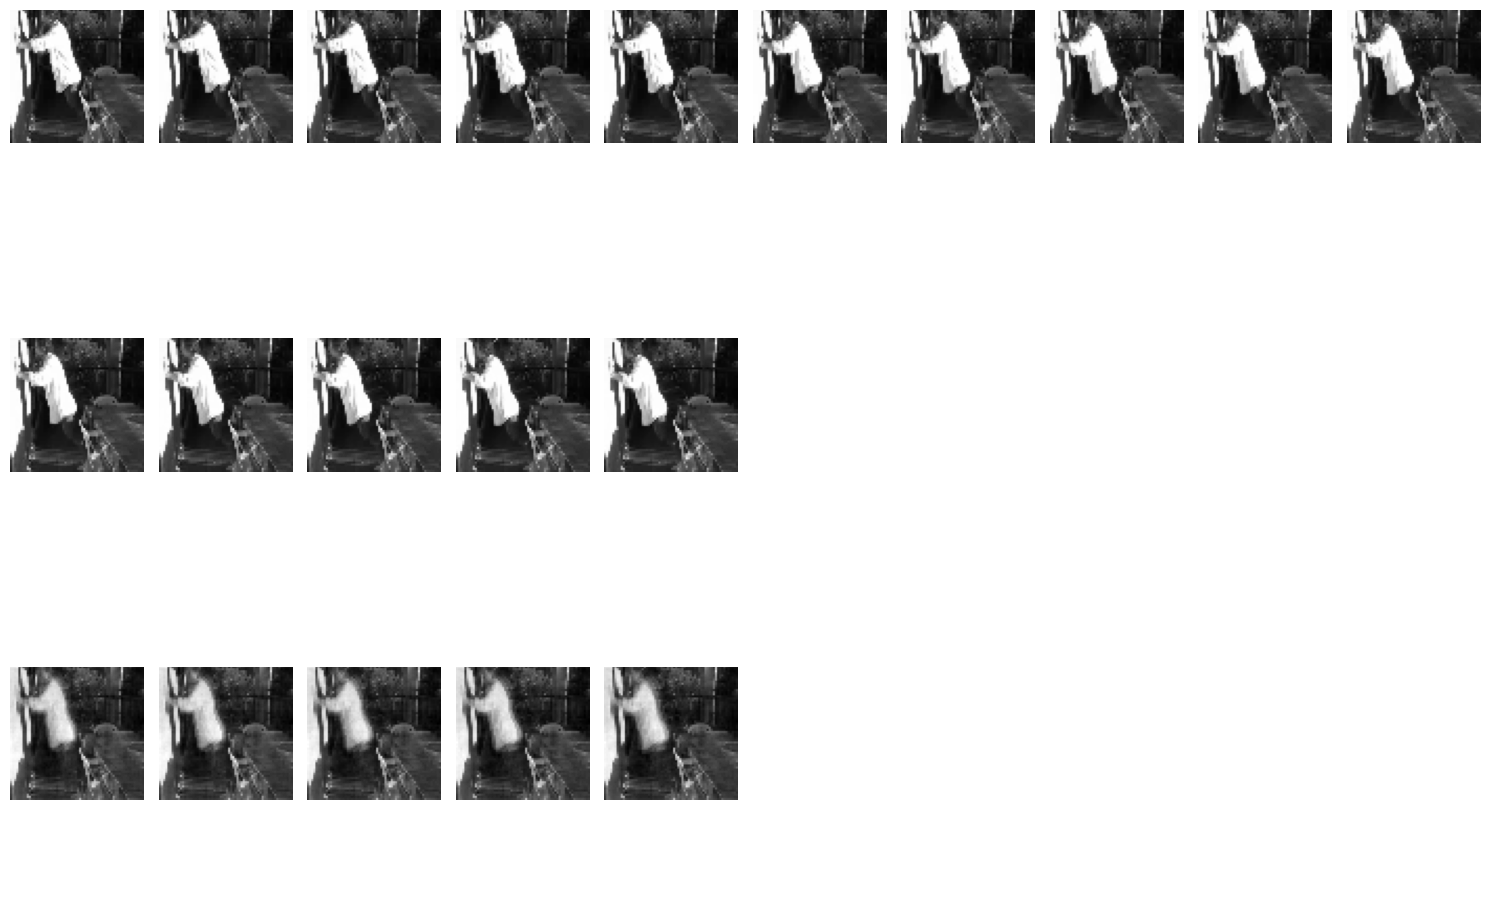

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Visualize Predictions Function
def visualize_predictions(model, dataset, idx=0):
    # Fetch a batch of data from the dataset
    for batch_idx, (X, Y) in enumerate(dataset.take(idx + 1)):
        if batch_idx == idx:
            input_seq = X.numpy()[0]  # Extract the first sample from the batch
            true_future = Y.numpy()[0]
            break

    # Predict the future frames
    predicted_future = model.predict(np.expand_dims(input_seq, axis=0))[0]

    # Adjust the number of rows for input and future frames
    rows = 3
    cols = max(INPUT_SEQ_LENGTH, OUTPUT_SEQ_LENGTH)

    # Plot Input Sequence, True Future, and Predicted Future
    fig, axs = plt.subplots(rows, cols, figsize=(15, 10))  # Increased figsize for larger frames

    # Plot Input Sequence
    for i in range(INPUT_SEQ_LENGTH):
        axs[0, i].imshow(input_seq[i, :, :, 0], cmap='gray')
        axs[0, i].axis('off')

    # Plot True Future Frames
    for i in range(OUTPUT_SEQ_LENGTH):
        axs[1, i].imshow(true_future[i, :, :, 0], cmap='gray')
        axs[1, i].axis('off')

    # Plot Predicted Future Frames
    for i in range(OUTPUT_SEQ_LENGTH):
        axs[2, i].imshow(predicted_future[i, :, :, 0], cmap='gray')
        axs[2, i].axis('off')

    # Hide unused subplots if INPUT_SEQ_LENGTH != OUTPUT_SEQ_LENGTH
    for i in range(cols):
        if i >= INPUT_SEQ_LENGTH:
            axs[0, i].axis('off')
        if i >= OUTPUT_SEQ_LENGTH:
            axs[1, i].axis('off')
            axs[2, i].axis('off')

    # Add row labels
    axs[0, 0].set_ylabel("Input Frames", fontsize=14, labelpad=20)
    axs[1, 0].set_ylabel("True Frames", fontsize=14, labelpad=20)
    axs[2, 0].set_ylabel("Predicted Frames", fontsize=14, labelpad=20)

    # Adjust layout and display
    plt.tight_layout()
    plt.show()

# Visualize results on validation dataset
visualize_predictions(model, val_dataset, idx=0)
